***Relevant Resources***
* Python Libraries for Networks and Graph Analysis - https://wiki.python.org/moin/PythonGraphLibraries
* CMS Risk Adjustment Information - https://www.cms.gov/Medicare/Health-Plans/MedicareAdvtgSpecRateStats/Risk-Adjustors
* Youtube | Network Analysis with Python - https://www.youtube.com/watch?v=oA7QhYOhW_0
* Tutorial on NLP-Inspired Network Embedding - https://arxiv.org/abs/1910.07212
* Common Neighbours | Neo4j - https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/common-neighbors/
* Node Similarity | Neo4j - https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/ , https://neo4j.com/docs/graph-data-science/current/algorithms/knn/
* node2vec | towardsdatascience - https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
* Attributed Random Walks as Matrix Factorisation - https://leichen2018.github.io/files/attr_rw_mf.pdf
* Representatin Learning on Graphs - Methods and Applications

***Unused Resources***
* Conceptual Graph Representation Framework for ICD-10 - https://www.researchgate.net/publication/276437750_Conceptual_Graph_Representation_Framework_for_ICD-10
* Graph Representation of Patient Data - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7067737/
* Pre-training of Graph Augmented Transformers for Medication Recommendation - https://arxiv.org/pdf/1906.00346.pdf
* MIT Graphs course (SG) - https://people.csail.mit.edu/jshun/6886-s18/
* ST-GCN

***Note***
* Only IP diagnosis have been considered for now


***Questions***
* Include OP data as well or create a separate graph DB for OP visits?
* How to do computations in case of a directed graph?


***Observations***
* Out of 10385 patients in this data, only 2438 patients have 2 or more HCCs, therefore sample set for making edge-weights is almost 1/4th
* Similarity scores are computed using the following formula - e_ij_sim = e_ij_intersection/e_ij_union (Jaccard's Similarity)
* Topological graph using similarity scores as weights is visually similar to the topological graph using count as weights
* There is evidence of relationships between the nearby HCC nodes documented in various research papers (however causal relationships are yet to be found, will probably be the next step...)
* To compute similarity between the non-connected nodes, we make use of 2nd degree proximity between the 2 nodes (the 2 nodes will be as similar to each other as the number of neighbours they have in common)
* Evidence of this is seen in connected nodes - 

#### Import Libraries

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from gensim.models import Word2Vec
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from sklearn.manifold import TSNE
from time import time
import warnings

warnings.filterwarnings('ignore')

#### Constants

In [2]:
# constants
metadata_columns = ['Diagnosis Code','Description','CMS-HCC Model Category V24']
inpatient_data_columns = ['empi','visit_id','visit_start_date','primary_diagnosis']
outpatient_data_columns = ['empi','visit_id','last_date_of_service','primary_diagnosis']

#### Read Data

In [3]:
# reading the risk adjustment metadata file
metadata = pd.read_csv("../data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv")

# reading the inpatient and outpatient data 
inpatient_data = pd.read_csv("../data/patient-data/df_preprocessed.csv")
outpatient_data = pd.read_csv("../data/patient-data/df_outpatient.csv")

#### Helper Functions

In [32]:
def prepare_metadata(metadata):
    """
    Cleans and prepares the HCC metadata file
    """
    # cleaning the risk adjustment metadata file
    metadata = metadata.iloc[2:-7,:]
    metadata.replace(r'\n',' ', regex=True, inplace=True)
    metadata.reset_index(drop=True, inplace=True)

    # creating the cleaned risk adjustment metadata dataframe
    new_metadata = pd.DataFrame(metadata.iloc[1:,:])
    new_metadata.columns = metadata.iloc[0,:].tolist()

    # filtering only the required columns from patient data and metadata
    new_metadata = new_metadata.loc[:,metadata_columns]
    new_metadata.columns = ['pd','dscr','hcc']
    new_metadata.loc[:,"hcc"] = new_metadata.hcc.fillna(0).astype('int')

    return new_metadata


def prepare_patient_data(inpatient_data, outpatient_data):
    """
    filters only the required columns from inpatient and outpatient data
    """
    inpatient_data = inpatient_data.loc[:,inpatient_data_columns]
    outpatient_data = outpatient_data.loc[:,outpatient_data_columns]

    inpatient_data.columns = ['empi','vid','vdt','pd']
    outpatient_data.columns = ['empi','vid','vdt','pd']

    return inpatient_data, outpatient_data


def create_patient_hcc_mapping(patient_df, hcc_df):
    """Maps ICD-10 codes to HCCs and prepares the data for 
    processing into adjacency matrices

    Args:
        patient_df (_type_): IP hospitalisation data
        hcc_df (_type_): HCC mapping for various (sub)models

    Returns:
        data: preprocessed data
    """
    join_params = {
    'left':patient_df,
    'right':metadata,
    'on':'pd',
    'how':'left'
    }
    data_merged = pd.merge(**join_params)
    data_hcc_dummies = pd.get_dummies(data_merged.hcc).iloc[:,1:]
    data = pd.concat([data_merged,data_hcc_dummies], axis=1)
    agg_dict = dict(zip(data_hcc_dummies.columns,np.repeat('sum', len(data_hcc_dummies.columns))))
    data = data.groupby('empi', as_index=False).aggregate(agg_dict)
    print("HCC Mapping done...")
    data.iloc[:,1:] = data.iloc[:,1:].ne(0)*1
    return data


def create_edge_table(data):
    """creates edge-table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    columns = data.drop('empi', axis=1).columns
    edge_data = pd.DataFrame(columns=['n_i','n_j','e_ij_intersection','e_ij_union','e_ij_sim'])
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            n_i = columns[i]
            n_j = columns[j]
            e_ij_intersection = data[[n_i,n_j]].all(axis=1).sum()
            e_ij_union = data[[n_i,n_j]].any(axis=1).sum()
            e_ij_sim = e_ij_intersection/e_ij_union
            edge_data = edge_data.append({'n_i':n_i,
                                          'n_j':n_j,
                                          'e_ij_intersection':e_ij_intersection,
                                          'e_ij_union':e_ij_union,
                                          'e_ij_sim':e_ij_sim
                                          }, ignore_index=True)
    edge_data = edge_data[edge_data.e_ij_sim!=0].reset_index(drop=True)
    print("Edge table preparation done...")
    return edge_data


def create_node_table(data):
    """Creates node table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    node_data = data.drop('empi', axis=1).sum()
    print("Node table preparation done...")
    return node_data


def filter_edge_data_by_node(node, edge_data):
    n_i = edge_data.columns[0]
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_i]==node
    filter2 = edge_data[n_j]==node
    return edge_data[filter1 | filter2].sort_values(weight)


def filter_edge_data_by_source_node(node, edge_data):
    n_i = edge_data.columns[0]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_i]==node
    return edge_data[filter1].sort_values(weight)


def filter_edge_data_by_target_node(node, edge_data):
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_j]==node
    return edge_data[filter1].sort_values(weight)


def plot_disease_graph(node_data, edge_data):

    # Storing data in a networkx graph object (for graph visualisation)
    G = nx.Graph()

    for node in node_data.index:
        G.add_node(node, hcc_count=node_data[node])

    for _, edges in edge_data.iterrows():
        G.add_edge(edges[0],edges[1], e_ij_sim=edges[4])

    # plotting IP disease graph
    plt.figure(figsize=(50,40))
    pos = nx.spring_layout(G, weight='e_ij_sim')
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=40)
    nx.draw_networkx_edge_labels(G, pos)
    plt.show()


def create_adjacency_matrices(edge_data):
    """
    Creates adjacency matrix of order 1 and proximity matrix
    of order 2"""
    hcc_set = set(edge_data.n_i) | set(edge_data.n_j)
    adjacency_matrix_1 = pd.DataFrame(0,columns=hcc_set, index=hcc_set)
    adjacency_matrix_2 = pd.DataFrame(0,columns=hcc_set, index=hcc_set)

    for _, edge in edge_data.iterrows():
        adjacency_matrix_1.loc[edge[0],edge[1]] = 1
        adjacency_matrix_1.loc[edge[1],edge[0]] = 1
    
    for i in range(adjacency_matrix_1.shape[0]):
        for j in range(i+1, adjacency_matrix_1.shape[0]):
            adjacency_matrix_2.iloc[i,j] = np.sum(adjacency_matrix_1.iloc[i,:]*adjacency_matrix_1.iloc[j,:])
            adjacency_matrix_2.iloc[j,i] = np.sum(adjacency_matrix_1.iloc[i,:]*adjacency_matrix_1.iloc[j,:])
    
    return adjacency_matrix_1, adjacency_matrix_2


def create_stellargraph(node_data, edge_data):
    node_data_df = pd.DataFrame({'x':node_data.values}, index=node_data.index).astype(float)
    edge_data_df = edge_data[['n_i','n_j','e_ij_sim']].copy().astype(float)
    edge_data_df.columns = ['source','target','weight']

    G = StellarGraph(node_data_df, edges=edge_data_df)
    return G


def biased_random_walk(G, weighted=False, n=100):
    """
    Performs biased random walk, return walks paths"""
    rw = BiasedRandomWalk(G)

    walks = rw.run(
        nodes=list(G.nodes()),  # root nodes
        length=20,  # maximum length of a random walk
        n=n,  # number of random walks per root node
        p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
        q=2,  # Defines (unormalised) probability, 1/q, for moving away from source node (intuitively, ratio of BFS:DFS)
        weighted=weighted,
        seed=42
    )
    print("Number of random walks: {}".format(len(walks)))
    return walks


def create_node_embeddings(walks, nodes_list):
    
    model = Word2Vec(walks, window=5, min_count=0, sg=1, workers=1)
    
    embeddings = pd.DataFrame()
    for node in nodes_list:
        embeddings[str(node)] = model.wv[int(node)]
    
    return embeddings


def TSNE_plot_node_embeddings(embeddings):

    transform = TSNE  # PCA
    trans = transform(n_components=2)
    tsne_coordinates = trans.fit_transform(embeddings.T)

    alpha = 0.7

    plt.figure(figsize=(20, 18))
    plt.axes().set(aspect="equal")
    plt.scatter(
        tsne_coordinates[:, 0],
        tsne_coordinates[:, 1],
        cmap="jet",
        alpha=alpha,
    )
    plt.title("{} visualization of node embeddings".format(transform.__name__))
    for i in range(tsne_coordinates.shape[0]):
        plt.annotate(embeddings.columns[i], (tsne_coordinates[i,0], tsne_coordinates[i,1]))
    plt.show()


def plot_embeddings_correlation(embeddings):
    plt.figure(figsize=(20,16))
    mask = np.triu(np.ones_like(embeddings.corr(), dtype=bool))
    sns.heatmap(embeddings.corr(), mask=mask)



#### Preparing Data

In [5]:
# preparing cleaned risk adjustment metadata
metadata = prepare_metadata(metadata)

# filtering only the required columns from inpatient and outpatient data
inpatient_data, outpatient_data = prepare_patient_data(inpatient_data, outpatient_data)

In [6]:
print(f"Patient Data: {inpatient_data.shape}\n{inpatient_data.head()}")
print(f"\nOutpatient Data: {outpatient_data.shape}\n{outpatient_data.head()}")
print(f"\nMetadata: {metadata.shape}\n{metadata.head()}")

Patient Data: (20541, 4)
          empi                               vid         vdt     pd
0  M0000040556  nM0000040556:1088927097671487508  2018-01-20  K5641
1  M0000040556  nM0000040556:1801256381439324181  2018-02-04   G458
2  M0000040556  nM0000040556:1339948222969081413  2018-02-18   K254
3  M0000040556  nM0000040556:1014145580172622435  2018-04-13  R5381
4  M0000040556   nM0000040556:130095445752129940  2018-06-27   I160

Outpatient Data: (371942, 4)
          empi                               vid         vdt      pd
0  M0000040556  nM0000040556:1002776852509021534  2018-06-03    N183
1  M0000040556  nM0000040556:1003353323421991148  2018-11-07  I87312
2  M0000040556  nM0000040556:1005893621657975338  2019-05-06   I2510
3  M0000040556  nM0000040556:1006150904029681462  2018-10-26  I69354
4  M0000040556  nM0000040556:1007502285099269954  2018-12-03   K8590

Metadata: (10981, 3)
      pd                   dscr  hcc
1  A0103      Typhoid pneumonia  115
2  A0104      Typhoid arthr

#### Inpatient Disease Embedding

In [9]:
# map PD to HCC and create node and edge tables from mapped data
data_raw_graph_ip = create_patient_hcc_mapping(inpatient_data, metadata)
node_data_ip = create_node_table(data_raw_graph_ip)
edge_data_ip = create_edge_table(data_raw_graph_ip)

HCC Mapping done...
Node table preparation done...
Edge table preparation done...


In [8]:
# dropping hcc 19 and hcc 122 because they dont have any edges (lack of inpatient data)
node_data_ip.drop(19.0, inplace=True)
node_data_ip.drop(122.0, inplace=True)

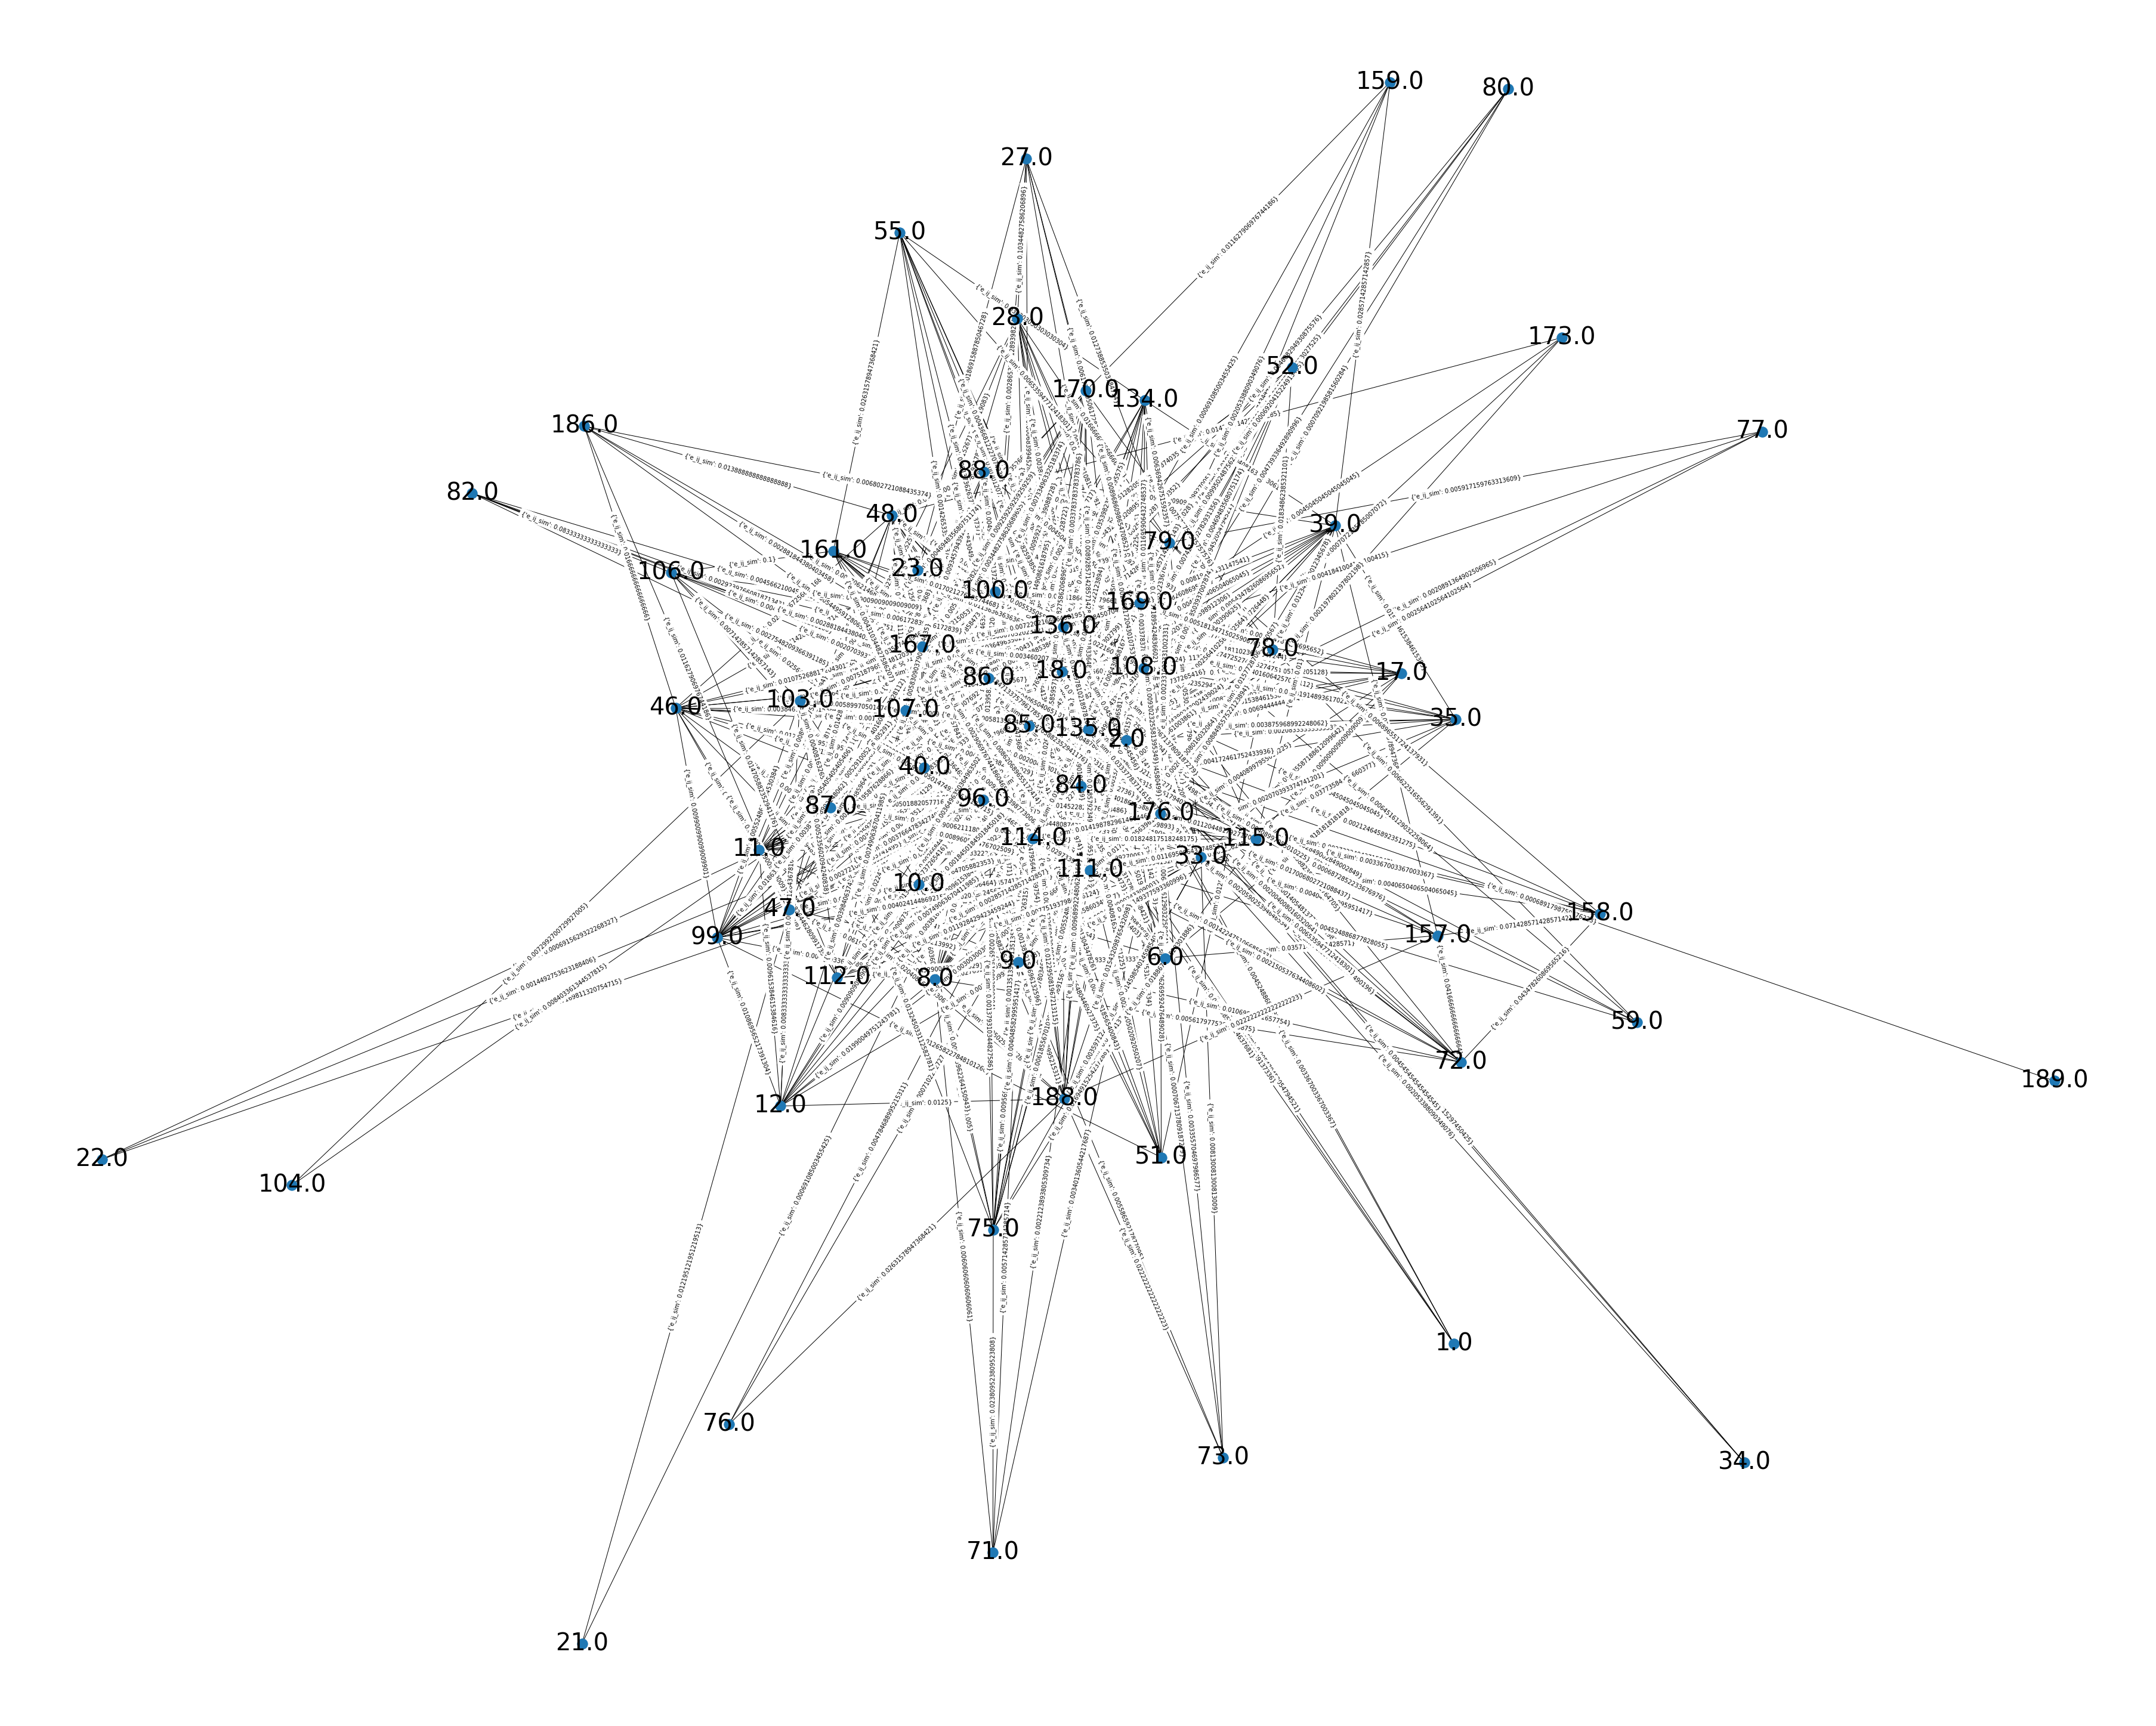

In [9]:
plot_disease_graph(node_data_ip, edge_data_ip)

In [10]:
adjacency_matrix_1, adjacency_matrix_2 = create_adjacency_matrices(edge_data_ip)

In [11]:
G_ip = create_stellargraph(node_data_ip, edge_data_ip)

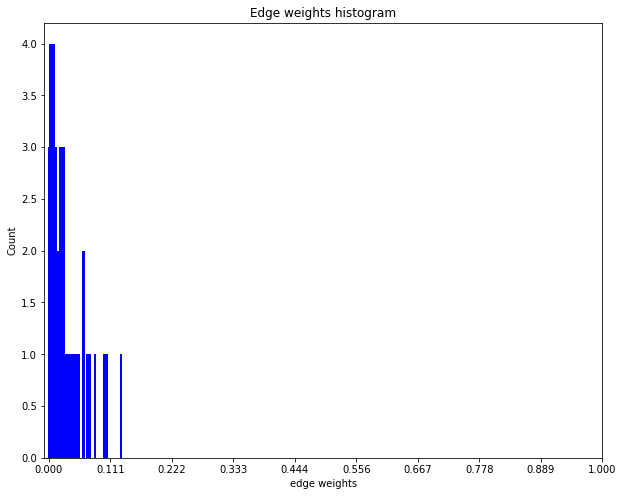

In [12]:
_, weights = G_ip.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [13]:
walks_ip = biased_random_walk(G_ip)

Number of random walks: 6900


In [586]:
# str_walks = [[str(n) for n in walk] for walk in walks]
# model = Word2Vec(str_walks, window=10, min_count=0, sg=1, workers=2)

In [14]:
embeddings_ip = create_node_embeddings(walks_ip, node_data_ip.index)

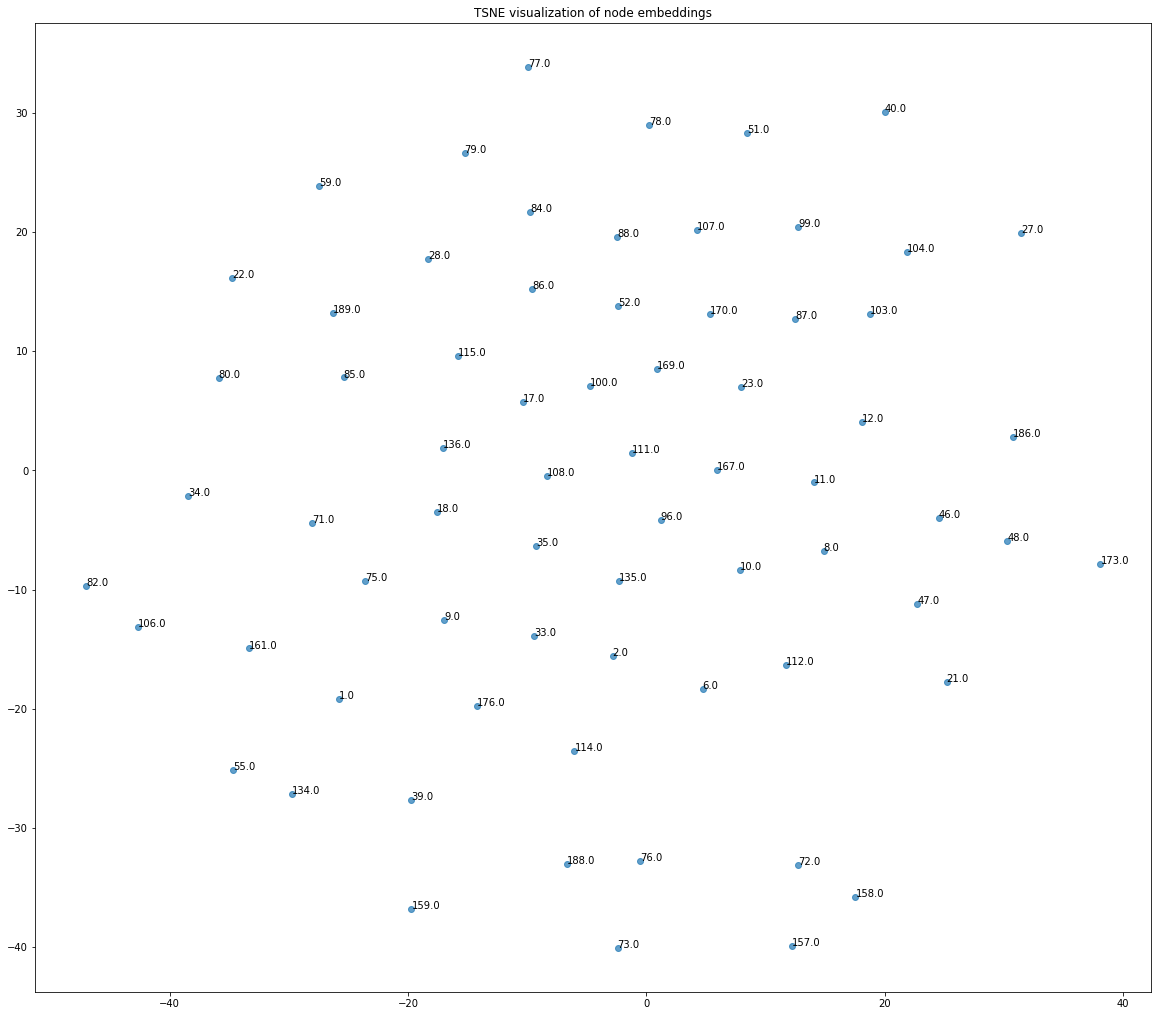

In [15]:
TSNE_plot_node_embeddings(embeddings_ip)

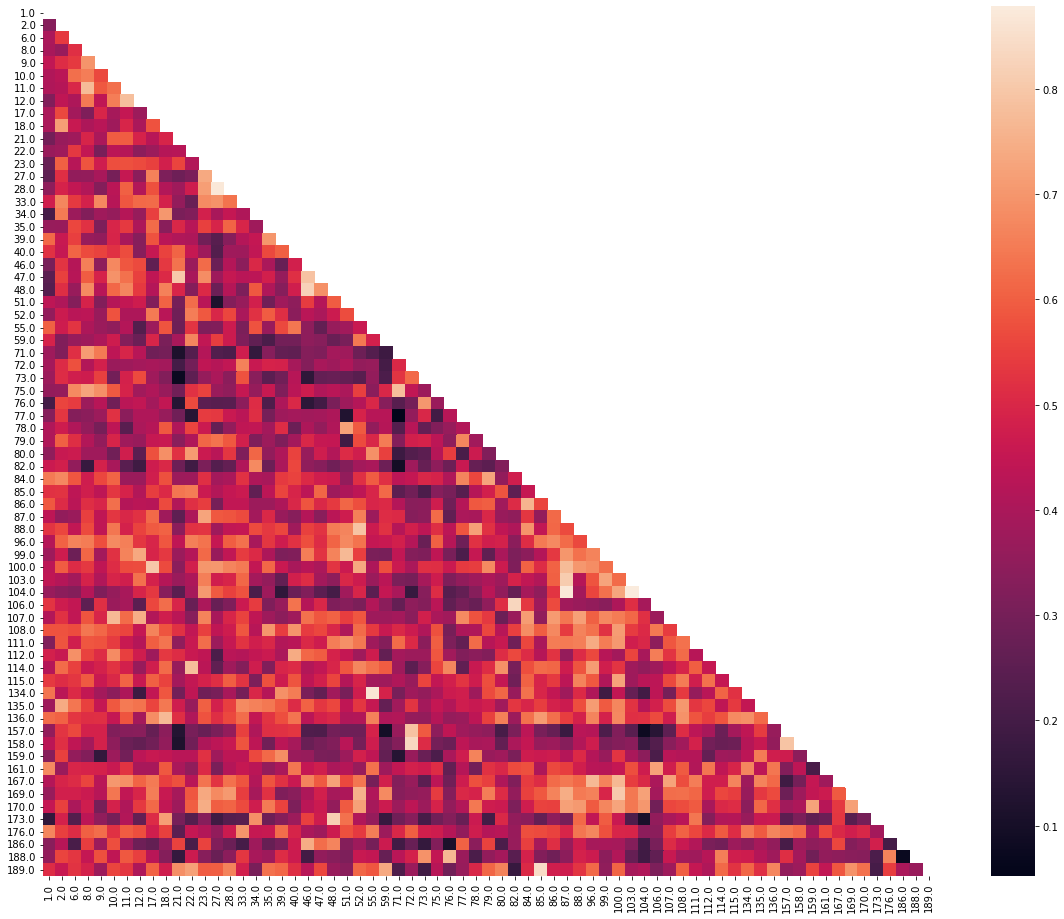

In [16]:
plot_embeddings_correlation(embeddings_ip)

#### Outpatient Disease Embeddings

In [17]:
# map PD to HCC and create node and edge tables from mapped data
data_raw_graph_op = create_patient_hcc_mapping(outpatient_data, metadata)
node_data_op = create_node_table(data_raw_graph_op)
edge_data_op = create_edge_table(data_raw_graph_op)

HCC Mapping done...
Node table preparation done...
Edge table preparation done...


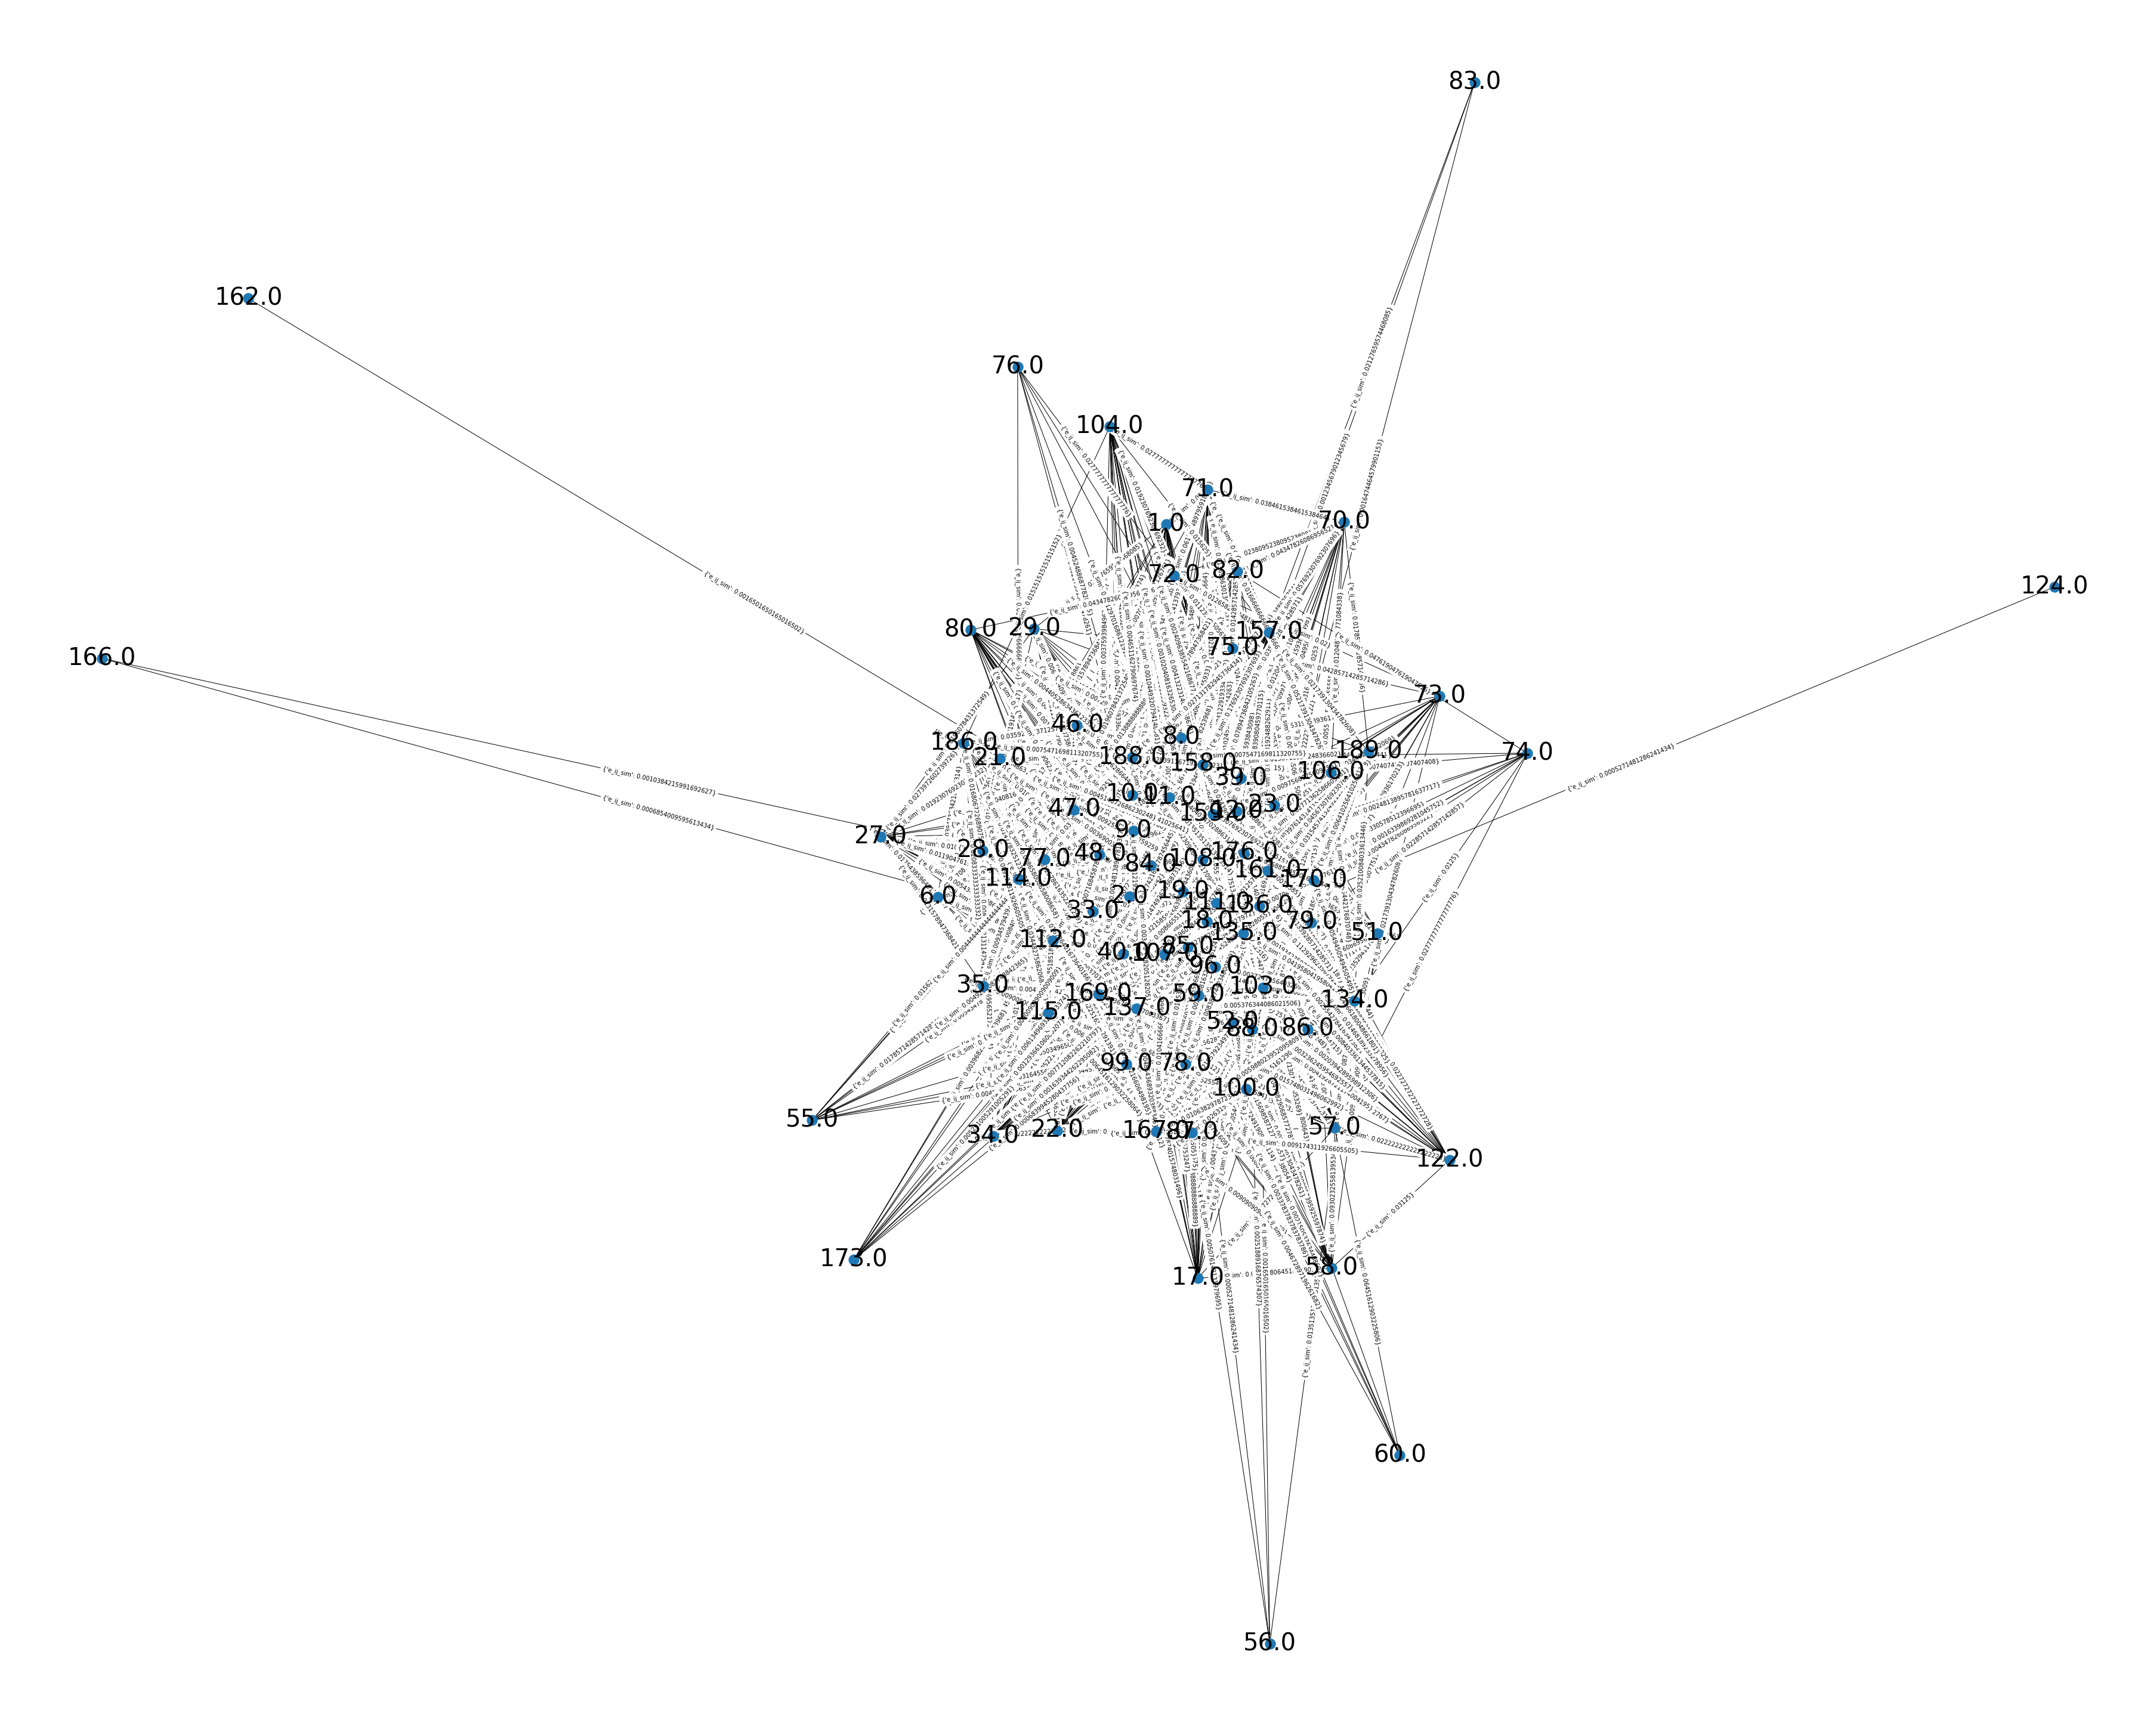

In [26]:
plot_disease_graph(node_data_op, edge_data_op)

In [27]:
G_op = create_stellargraph(node_data_op, edge_data_op)

In [28]:
walks_op = biased_random_walk(G_op)

Number of random walks: 8300


In [29]:
embeddings_op = create_node_embeddings(walks_op, node_data_op.index)

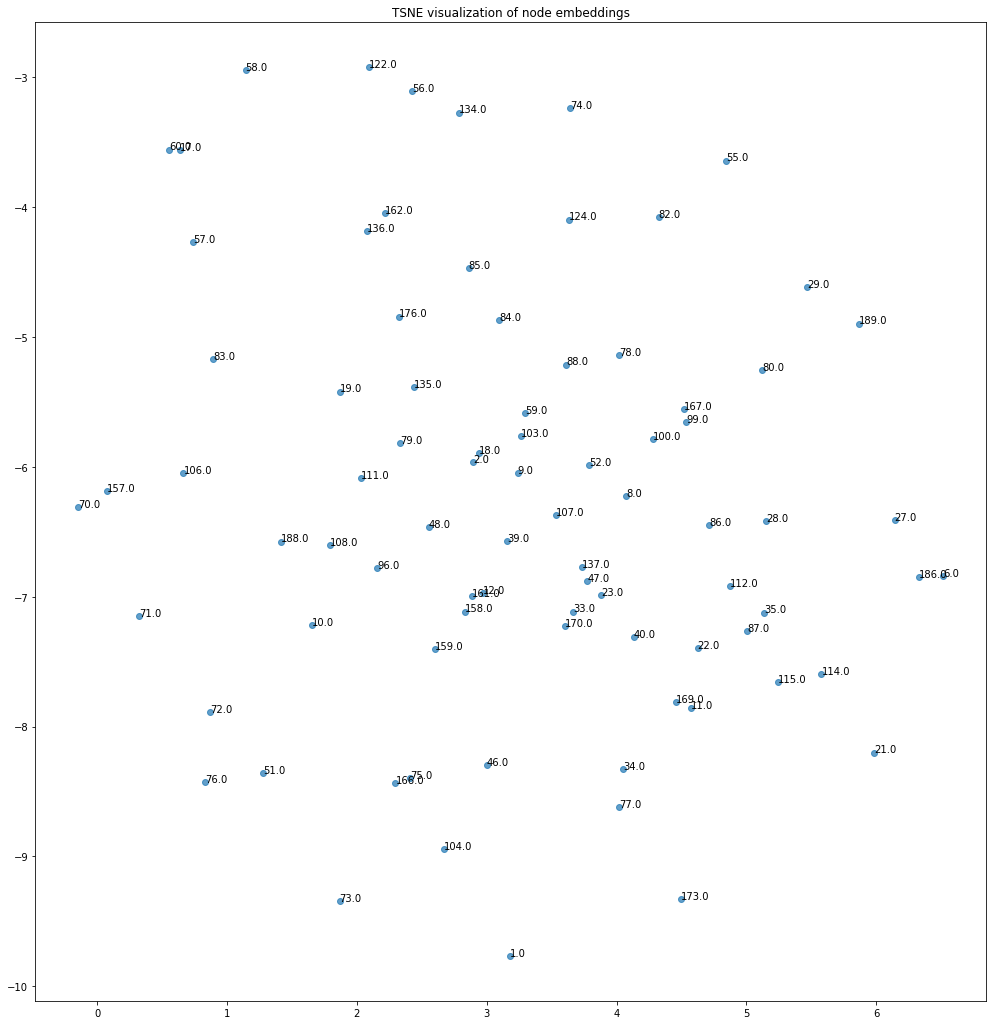

In [30]:
TSNE_plot_node_embeddings(embeddings_op)

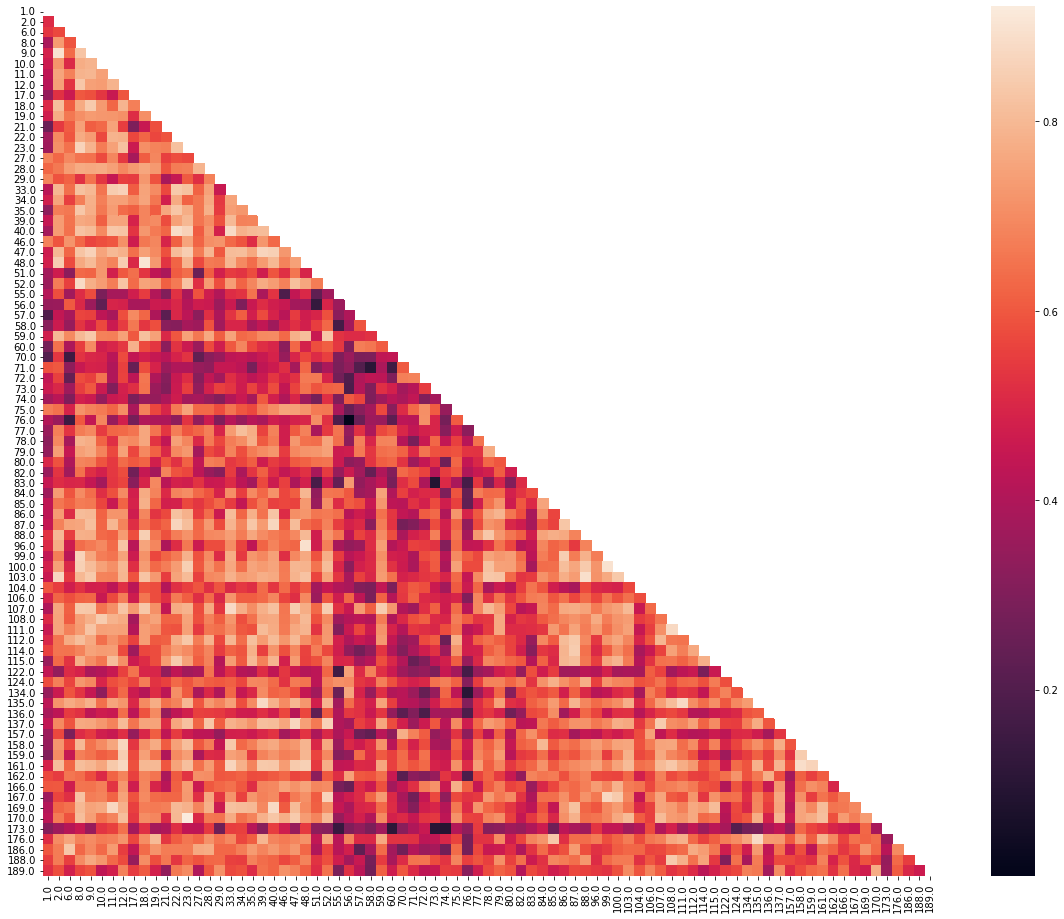

In [31]:
plot_embeddings_correlation(embeddings_op)

<AxesSubplot:>

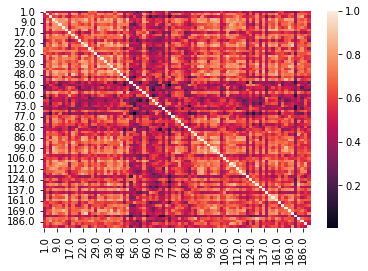

In [32]:
sns.heatmap(embeddings_op.corr())

#### Combining IP and OP Data

In [7]:
data_combined = pd.concat([inpatient_data, outpatient_data], axis=0)

# map PD to HCC and create node and edge tables from mapped data
data_raw_graph = create_patient_hcc_mapping(data_combined, metadata)
node_data = create_node_table(data_raw_graph)
edge_data = create_edge_table(data_raw_graph)

HCC Mapping done...
Node table preparation done...
Edge table preparation done...


#### Combining IP and OP Data

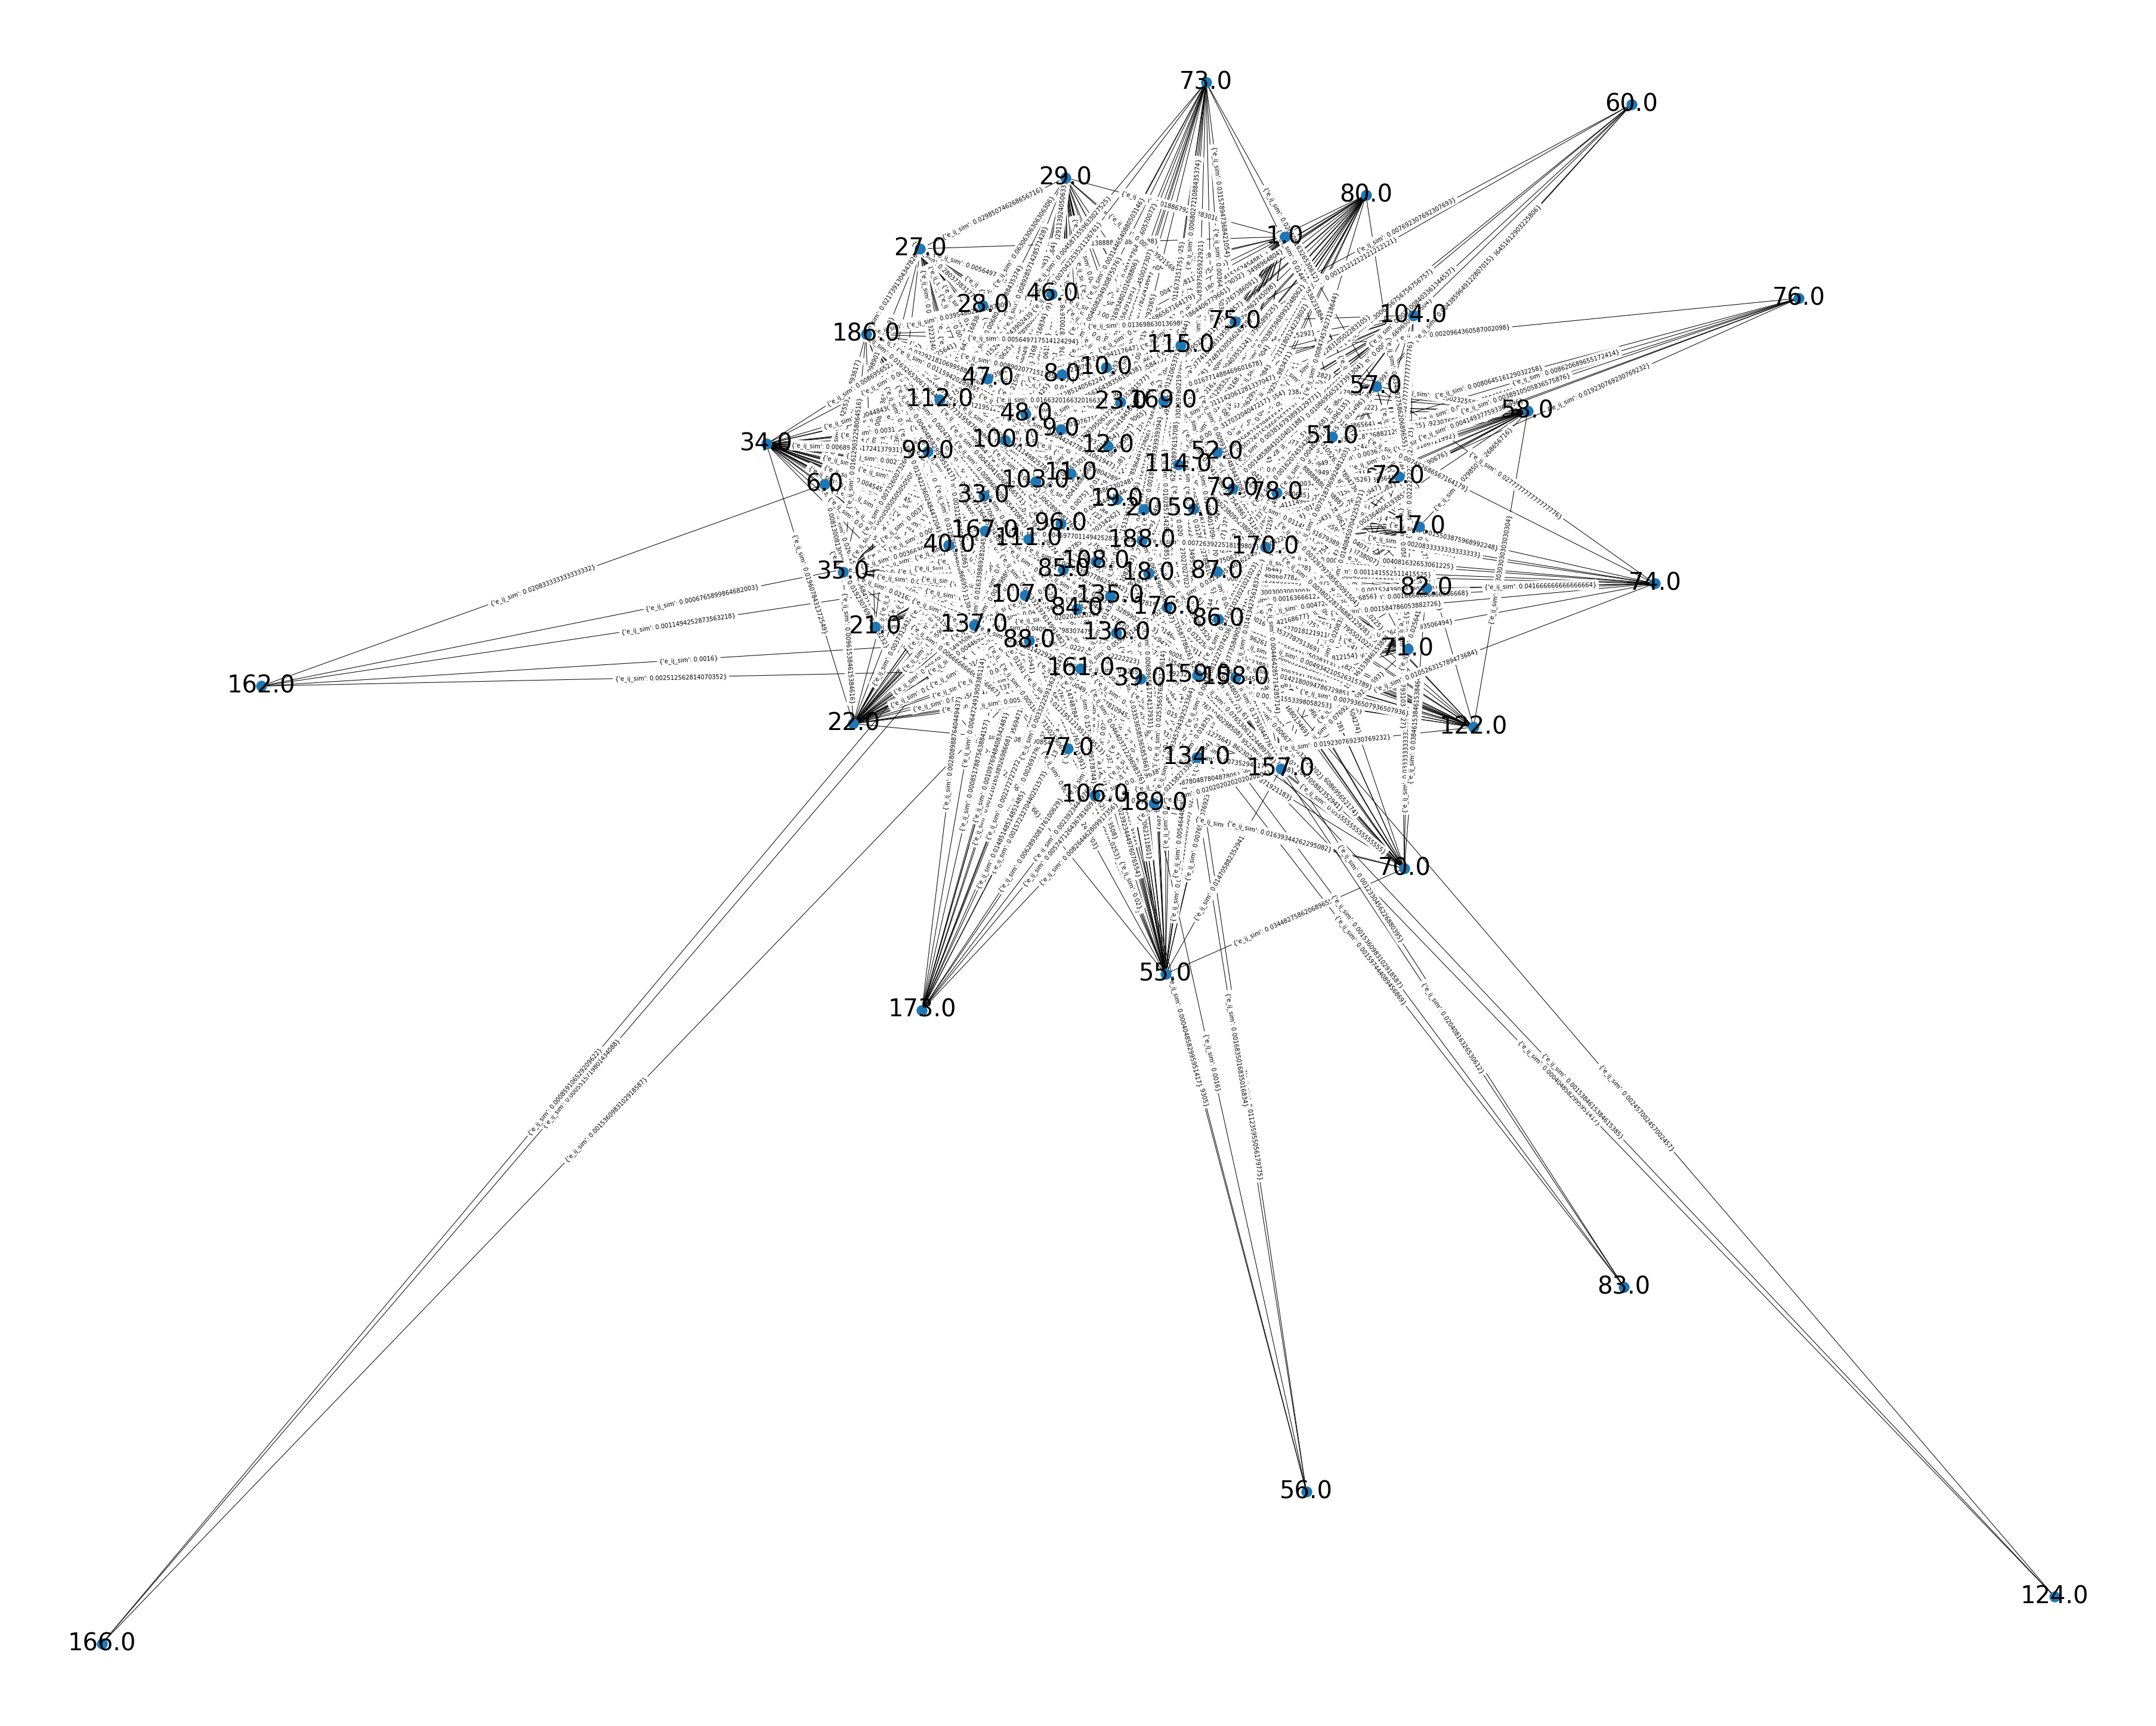

In [8]:
plot_disease_graph(node_data, edge_data)

In [9]:
G = create_stellargraph(node_data, edge_data)
walks = biased_random_walk(G, n=100)
embeddings = create_node_embeddings(walks, node_data.index)

Number of random walks: 8300


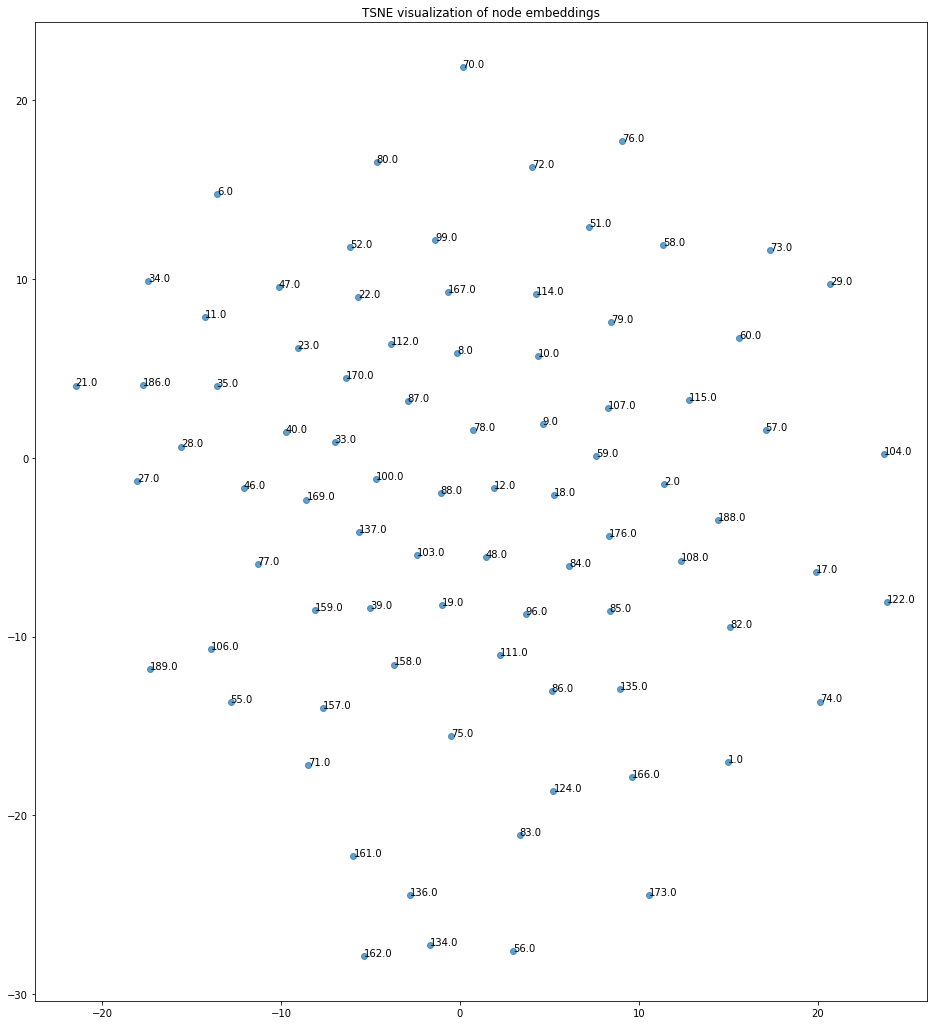

In [10]:
TSNE_plot_node_embeddings(embeddings)

In [11]:
filter_edge_data_by_node(157,edge_data).sort_values('e_ij_sim')

n_i    n_j  e_ij_intersection  e_ij_union  e_ij_sim
1914  111.0  157.0                1.0      1210.0  0.000826
269     9.0  157.0                1.0       870.0  0.001149
203     8.0  157.0                1.0       590.0  0.001695
452    12.0  157.0                2.0      1058.0  0.001890
1733   88.0  157.0                1.0       422.0  0.002370
1827  103.0  157.0                1.0       386.0  0.002591
1154   48.0  157.0                1.0       346.0  0.002890
1760   96.0  157.0                6.0      1854.0  0.003236
390    11.0  157.0                2.0       579.0  0.003454
1035   40.0  157.0                1.0       287.0  0.003484
1653   85.0  157.0                9.0      2509.0  0.003587
730    23.0  157.0                1.0       267.0  0.003745
1348   59.0  157.0                2.0       520.0  0.003846
1683   86.0  157.0                2.0       453.0  0.004415
2031  157.0  170.0                1.0       224.0  0.004464
2006  136.0  157.0                3.0       670.0  0.004478
615    19.0  157.0                5.0       853.0  0.005862
1783   99.0  157.0                1.0       170.0  0.005882
1947  114.0  157.0                2.0       293.0  0.006826
554    18.0  157.0                9.0      1266.0  0.007109
1621   84.0  157.0                4.0       562.0  0.007117
1982  134.0  157.0                1.0       136.0  0.007353
1893  108.0  157.0                7.0       911.0  0.007684
1227   52.0  157.0                4.0       518.0  0.007722
1470   75.0  157.0                1.0       125.0  0.008000
1993  135.0  157.0                6.0       692.0  0.008671
880    33.0  157.0                4.0       389.0  0.010283
1874  107.0  157.0                5.0       479.0  0.010438
144     6.0  157.0                1.0        95.0  0.010526
93      2.0  157.0               18.0      1508.0  0.011936
650    21.0  157.0                1.0        77.0  0.012987
1841  104.0  157.0                1.0        71.0  0.014085
1256   55.0  157.0                1.0        68.0  0.014706
1593   82.0  157.0                1.0        65.0  0.015385
2030  157.0  161.0                7.0       439.0  0.015945
2034  157.0  189.0                2.0        99.0  0.020202
1599   83.0  157.0                1.0        49.0  0.020408
1416   72.0  157.0                2.0        96.0  0.020833
2032  157.0  176.0               17.0       625.0  0.027200
2033  157.0  188.0                8.0       279.0  0.028674
1499   77.0  157.0                4.0       119.0  0.033613
1855  106.0  157.0                6.0       123.0  0.048780
1372   70.0  157.0                3.0        54.0  0.055556
2029  157.0  159.0               15.0       196.0  0.076531
1390   71.0  157.0                5.0        65.0  0.076923
991    39.0  157.0               14.0       182.0  0.076923
2028  157.0  158.0               24.0       134.0  0.179104

In [14]:
filter_edge_data_by_node(1, edge_data).sort_values('e_ij_sim', ascending=False)

n_i    n_j  e_ij_intersection  e_ij_union  e_ij_sim
13  1.0   71.0                1.0        50.0  0.020000
9   1.0   29.0                1.0        53.0  0.018868
7   1.0   27.0                1.0        72.0  0.013889
1   1.0    6.0                1.0        76.0  0.013158
4   1.0   17.0                1.0        80.0  0.012500
27  1.0  176.0                6.0       617.0  0.009724
14  1.0   84.0                5.0       542.0  0.009225
23  1.0  134.0                1.0       117.0  0.008547
8   1.0   28.0                1.0       121.0  0.008264
12  1.0   59.0                4.0       499.0  0.008016
25  1.0  136.0                5.0       649.0  0.007704
22  1.0  115.0                1.0       156.0  0.006410
10  1.0   46.0                1.0       162.0  0.006173
11  1.0   48.0                2.0       326.0  0.006135
24  1.0  135.0                4.0       675.0  0.005926
6   1.0   19.0                4.0       835.0  0.004790
26  1.0  161.0                2.0       425.0  0.004706
20  1.0  108.0                4.0       895.0  0.004469
28  1.0  188.0                1.0       267.0  0.003745
19  1.0  103.0                1.0       367.0  0.002725
17  1.0   88.0                1.0       403.0  0.002481
5   1.0   18.0                3.0      1253.0  0.002394
16  1.0   86.0                1.0       435.0  0.002299
3   1.0   10.0                1.0       503.0  0.001988
21  1.0  111.0                2.0      1190.0  0.001681
18  1.0   96.0                3.0      1838.0  0.001632
15  1.0   85.0                4.0      2495.0  0.001603
0   1.0    2.0                2.0      1505.0  0.001329
2   1.0    9.0                1.0       851.0  0.001175

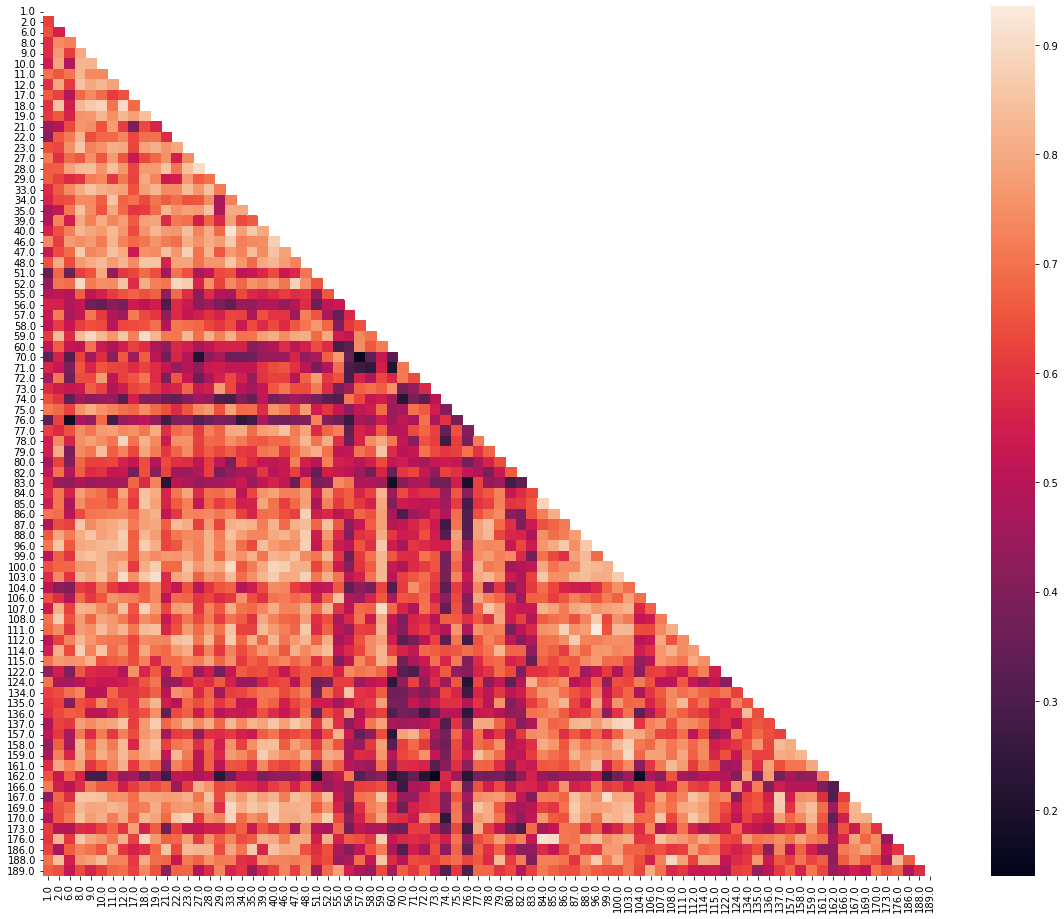

In [19]:
plot_embeddings_correlation(embeddings)

In [20]:
adjacency_matrix_1, adjacency_matrix_2 = create_adjacency_matrices(edge_data)

In [21]:
adjacency_matrix_1

1.0    2.0    6.0    8.0    9.0    10.0   11.0   12.0   17.0   18.0   \
1.0        0      1      1      0      1      1      0      0      1      1   
2.0        1      0      1      1      1      1      1      1      1      1   
6.0        1      1      0      1      1      1      1      1      0      1   
8.0        0      1      1      0      1      1      1      1      0      1   
9.0        1      1      1      1      0      1      1      1      1      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
173.0      0      1      0      0      0      1      1      1      0      1   
176.0      1      1      1      1      1      1      1      1      1      1   
186.0      0      1      1      1      1      1      1      1      0      1   
188.0      1      1      1      1      1      1      1      1      1      1   
189.0      0      1      0      0      1      0      0      1      0      1   

       ...  162.0  166.0  167.0  169.0  170.0  173.0  176.0  186.0  188.0  \
1.0    ...      0      0      0      0      0      0      1      0      1   
2.0    ...      1      0      1      1      1      1      1      1      1   
6.0    ...      1      0      0      1      1      0      1      1      1   
8.0    ...      0      0      1      1      1      0      1      1      1   
9.0    ...      0      0      1      1      1      0      1      1      1   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
173.0  ...      0      0      0      1      0      0      0      0      0   
176.0  ...      0      0      1      1      1      0      0      1      1   
186.0  ...      0      0      1      1      1      0      1      0      1   
188.0  ...      0      0      1      1      1      0      1      1      0   
189.0  ...      0      0      0      0      1      0      1      0      1   

       189.0  
1.0        0  
2.0        1  
6.0        0  
8.0        0  
9.0        1  
...      ...  
173.0      0  
176.0      1  
186.0      0  
188.0      1  
189.0      0  

[83 rows x 83 columns]

In [22]:
adjacency_matrix_2

1.0    2.0    6.0    8.0    9.0    10.0   11.0   12.0   17.0   18.0   \
1.0        0     28     25     26     28     27     28     28     22     28   
2.0       28      0     47     62     70     68     61     68     40     74   
6.0       25     47      0     44     46     44     45     44     32     46   
8.0       26     62     44      0     60     59     57     62     39     62   
9.0       28     70     46     60      0     64     60     65     39     70   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
173.0     12     19     17     20     20     19     19     19     19     19   
176.0     28     73     46     62     69     66     60     67     40     72   
186.0     25     44     38     42     44     44     43     42     31     44   
188.0     27     67     45     57     65     61     57     61     39     65   
189.0     22     36     29     35     35     35     35     36     29     36   

       ...  162.0  166.0  167.0  169.0  170.0  173.0  176.0  186.0  188.0  \
1.0    ...      5      3     26     26     25     12     28     25     27   
2.0    ...      4      3     59     59     56     19     73     44     67   
6.0    ...      4      3     43     42     43     17     46     38     45   
8.0    ...      5      3     53     53     54     20     62     42     57   
9.0    ...      5      3     57     57     55     20     69     44     65   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
173.0  ...      4      2     20     19     20      0     20     18     20   
176.0  ...      5      3     59     58     56     20      0     44     66   
186.0  ...      5      3     41     42     41     18     44      0     44   
188.0  ...      5      3     54     54     51     20     66     44      0   
189.0  ...      4      3     35     33     34     16     36     29     34   

       189.0  
1.0       22  
2.0       36  
6.0       29  
8.0       35  
9.0       35  
...      ...  
173.0     16  
176.0     36  
186.0     29  
188.0     34  
189.0      0  

[83 rows x 83 columns]

In [23]:
adjacency_matrix_3 = adjacency_matrix_2/adjacency_matrix_2.sum()

In [24]:
adjacency_matrix_3

1.0       2.0       6.0       8.0       9.0       10.0      11.0   \
1.0    0.000000  0.007016  0.008639  0.007202  0.007216  0.007169  0.007795   
2.0    0.015385  0.000000  0.016240  0.017175  0.018041  0.018056  0.016982   
6.0    0.013736  0.011776  0.000000  0.012188  0.011856  0.011683  0.012528   
8.0    0.014286  0.015535  0.015204  0.000000  0.015464  0.015666  0.015869   
9.0    0.015385  0.017539  0.015895  0.016620  0.000000  0.016994  0.016704   
...         ...       ...       ...       ...       ...       ...       ...   
173.0  0.006593  0.004761  0.005874  0.005540  0.005155  0.005045  0.005290   
176.0  0.015385  0.018291  0.015895  0.017175  0.017784  0.017525  0.016704   
186.0  0.013736  0.011025  0.013131  0.011634  0.011340  0.011683  0.011971   
188.0  0.014835  0.016788  0.015549  0.015789  0.016753  0.016198  0.015869   
189.0  0.012088  0.009020  0.010021  0.009695  0.009021  0.009294  0.009744   

          12.0      17.0      18.0   ...     162.0     166.0     167.0  \
1.0    0.007316  0.008517  0.007055  ...  0.014970  0.013889  0.007480   
2.0    0.017768  0.015486  0.018644  ...  0.011976  0.013889  0.016974   
6.0    0.011497  0.012389  0.011590  ...  0.011976  0.013889  0.012371   
8.0    0.016201  0.015099  0.015621  ...  0.014970  0.013889  0.015247   
9.0    0.016985  0.015099  0.017637  ...  0.014970  0.013889  0.016398   
...         ...       ...       ...  ...       ...       ...       ...   
173.0  0.004965  0.007356  0.004787  ...  0.011976  0.009259  0.005754   
176.0  0.017507  0.015486  0.018141  ...  0.014970  0.013889  0.016974   
186.0  0.010975  0.012002  0.011086  ...  0.014970  0.013889  0.011795   
188.0  0.015939  0.015099  0.016377  ...  0.014970  0.013889  0.015535   
189.0  0.009407  0.011227  0.009070  ...  0.011976  0.013889  0.010069   

          169.0     170.0     173.0     176.0     186.0     188.0     189.0  
1.0    0.007374  0.007340  0.008895  0.007069  0.008894  0.007250  0.009442  
2.0    0.016733  0.016442  0.014085  0.018430  0.015653  0.017991  0.015451  
6.0    0.011912  0.012625  0.012602  0.011613  0.013518  0.012084  0.012446  
8.0    0.015031  0.015854  0.014826  0.015653  0.014941  0.015306  0.015021  
9.0    0.016166  0.016148  0.014826  0.017420  0.015653  0.017454  0.015021  
...         ...       ...       ...       ...       ...       ...       ...  
173.0  0.005389  0.005872  0.000000  0.005049  0.006403  0.005371  0.006867  
176.0  0.016449  0.016442  0.014826  0.000000  0.015653  0.017723  0.015451  
186.0  0.011912  0.012038  0.013343  0.011108  0.000000  0.011815  0.012446  
188.0  0.015315  0.014974  0.014826  0.016662  0.015653  0.000000  0.014592  
189.0  0.009359  0.009982  0.011861  0.009089  0.010317  0.009130  0.000000  

[83 rows x 83 columns]

## Pagerank
Reference for implementation - https://www.briggsby.com/personalized-pagerank

In [26]:
D = nx.DiGraph()

In [12]:
join_params = {
'left':data_combined,
'right':metadata,
'on':'pd',
'how':'left'
}

data_combined_pagerank = pd.merge(**join_params)

In [13]:
data_combined_pagerank['hcc'] = data_combined_pagerank.hcc.replace(0,np.nan)
data_combined_pagerank = data_combined_pagerank.dropna()
data_combined_pagerank = data_combined_pagerank.sort_values(['empi','vdt']).reset_index(drop=True)
data_combined_pagerank["hcc_nxt"] = data_combined_pagerank.hcc.shift(-1)
index_drop = data_combined_pagerank.groupby('empi').tail(1).index
data_combined_pagerank = data_combined_pagerank.drop(index_drop)
data_combined_pagerank = data_combined_pagerank[data_combined_pagerank.hcc!=data_combined_pagerank.hcc_nxt].reset_index(drop=True)

In [14]:
data_combined_pagerank = data_combined_pagerank[['hcc','hcc_nxt']].astype(str)
data_combined_pagerank['edge'] = data_combined_pagerank.hcc + ", " + data_combined_pagerank.hcc_nxt
data_combined_pagerank['cnt'] = 1

In [15]:
edge_data_pagerank = data_combined_pagerank.groupby(['hcc','hcc_nxt'], as_index=False).agg({'cnt':'count'})
edge_data_pagerank.columns = ['source','target','weight']

In [16]:
adjacency_matrix_pagerank = data_combined_pagerank.groupby(['hcc','hcc_nxt']).agg({'cnt':'count'}).unstack().fillna(0)
adjacency_matrix_pagerank.columns = adjacency_matrix_pagerank.columns.get_level_values(1)

In [17]:
adjacency_matrix_pagerank

hcc_nxt  1.0  10.0  100.0  103.0  104.0  106.0  107.0  108.0  11.0  111.0  \
hcc                                                                         
1.0      0.0   1.0    0.0    1.0    0.0    0.0    0.0    2.0   0.0    1.0   
10.0     1.0   0.0    7.0    9.0    0.0    0.0    4.0   22.0  34.0   23.0   
100.0    0.0   3.0    0.0   59.0    5.0    0.0    1.0    5.0   4.0    6.0   
103.0    1.0   7.0   34.0    0.0    2.0    0.0    5.0    7.0   0.0   10.0   
104.0    0.0   1.0    2.0    2.0    0.0    0.0    0.0    0.0   0.0    0.0   
...      ...   ...    ...    ...    ...    ...    ...    ...   ...    ...   
87.0     0.0   4.0    6.0    2.0    0.0    0.0    2.0    4.0   4.0    3.0   
88.0     0.0   5.0    5.0    2.0    0.0    0.0    2.0    8.0  10.0   17.0   
9.0      0.0  90.0   23.0    8.0    2.0    1.0   19.0   36.0  75.0  100.0   
96.0     1.0  37.0   25.0   24.0    2.0    5.0   27.0   43.0  33.0   70.0   
99.0     0.0   1.0    4.0   18.0    0.0    0.0    2.0    2.0   1.0    1.0   

hcc_nxt  ...  82.0  83.0  84.0   85.0  86.0  87.0  88.0   9.0  96.0  99.0  
hcc      ...                                                               
1.0      ...   0.0   0.0   1.0    2.0   0.0   0.0   0.0   1.0   2.0   0.0  
10.0     ...   2.0   0.0  12.0   48.0   3.0   4.0   5.0  91.0  32.0   3.0  
100.0    ...   0.0   0.0   4.0   18.0   4.0   2.0   2.0  19.0  37.0   1.0  
103.0    ...   0.0   0.0   5.0   20.0   2.0   1.0   2.0  10.0  23.0  15.0  
104.0    ...   0.0   0.0   1.0    0.0   0.0   1.0   0.0   1.0   1.0   0.0  
...      ...   ...   ...   ...    ...   ...   ...   ...   ...   ...   ...  
87.0     ...   0.0   0.0   0.0   24.0   3.0   0.0  12.0   3.0  16.0   1.0  
88.0     ...   0.0   0.0   4.0   30.0   7.0  15.0   0.0   7.0  33.0   1.0  
9.0      ...   1.0   0.0  34.0   83.0  11.0   3.0   8.0   0.0  61.0   4.0  
96.0     ...   0.0   0.0  28.0  396.0  16.0  10.0  35.0  64.0   0.0   5.0  
99.0     ...   0.0   0.0   2.0    5.0   0.0   0.0   0.0   2.0   4.0   0.0  

[82 rows x 83 columns]

In [18]:
G = nx.from_pandas_edgelist(edge_data_pagerank, 'source', 'target', create_using=nx.DiGraph)
G_weighted = nx.from_pandas_edgelist(edge_data_pagerank, 'source', 'target', create_using=nx.DiGraph, edge_attr='weight')


In [25]:
weighted_pagerank = nx.pagerank(G_weighted, alpha=0.85)

df_metrics = pd.DataFrame(dict(
    weighted_pagerank = weighted_pagerank))
df_metrics.index.name='hcc'

In [26]:
df_metrics.sort_values('weighted_pagerank')

weighted_pagerank
hcc                     
56.0            0.001849
162.0           0.001849
166.0           0.001849
124.0           0.001869
83.0            0.001887
...                  ...
9.0             0.040338
161.0           0.049390
18.0            0.075559
85.0            0.077229
136.0           0.080715

[83 rows x 1 columns]

In [28]:
target_nodes = filter_edge_data_by_source_node(str(157.0), edge_data_pagerank).target

In [29]:
target_nodes

772    103.0
801     86.0
799     84.0
798     83.0
797      8.0
796     77.0
795     72.0
793     70.0
792     59.0
791     55.0
788     23.0
802      9.0
786     19.0
803     96.0
777    114.0
776     11.0
773    106.0
790     48.0
774    107.0
778    135.0
794     71.0
782    161.0
781    159.0
783    176.0
785    188.0
775    108.0
800     85.0
787      2.0
784     18.0
789     39.0
779    136.0
780    158.0
Name: target, dtype: object

In [30]:
edge_data_pagerank

source target  weight
0       1.0   10.0       1
1       1.0  103.0       1
2       1.0  108.0       2
3       1.0  111.0       1
4       1.0  115.0       1
...     ...    ...     ...
2747   99.0    8.0       1
2748   99.0   84.0       2
2749   99.0   85.0       5
2750   99.0    9.0       2
2751   99.0   96.0       4

[2752 rows x 3 columns]

In [72]:
importances = df_metrics.loc[['136.0'],:]

In [75]:
weights = filter_edge_data_by_target_node('158.0', edge_data_pagerank)
weights = weights[weights.source.isin(['136.0'])].weight

In [74]:
importances.values[0][0]

0.08071549390623738

In [76]:
weights.values[0]

13

In [77]:
in_degree = compute_in_degree(136, edge_data_pagerank)
in_degree

3122

In [70]:
importances.values[0][0] * weights.values[0] / in_degree

0.0016801303103657229

In [78]:
importances.values[0][0] * weights.values[0] / in_degree

0.000336099109795351

In [65]:
in_degree

<function __main__.in_degree(node, edge_data)>

In [67]:
def compute_in_degree(node, edge_data):
    """Computes the in-degree of node

    Args:
        node (_type_): _description_
        edge_data (_type_): _description_
    """
    return filter_edge_data_by_target_node(str(float(node)), edge_data).weight.sum()

* Lets suppose the patient has `HCC18` (`Diabetes with Chronic Complications`) and `HCC136` (`CKD Stage 5`) conditions
* Next step is to find out the importances of the neighbours of the HCC18 and HCC136 nodes, where these HCCs are the `source` node only - DOESNT WORK - Reason - The importances need to be multiplied by the probability of reaching that node which is = out_ij/sum x E N(i) (out_ix)
* Next step - find out the N(i), compute the source node out probabilities to the N(i) and multiply by the target node importance

In [495]:
filter_edge_data_by_node(str(157.0), edge_data_pagerank)

source target  weight
796  157.0   77.0       1
797  157.0    8.0       1
793  157.0   70.0       1
792  157.0   59.0       1
791  157.0   55.0       1
..     ...    ...     ...
789  157.0   39.0      18
683  136.0  157.0      23
779  157.0  136.0      24
813  158.0  157.0      38
780  157.0  158.0      41

[63 rows x 3 columns]

In [475]:
source_node_edge_weights = filter_edge_data_by_source_node(str(111.0), edge_data_pagerank)

In [476]:
target_node_probabilities = source_node_edge_weights.weight / source_node_edge_weights.weight.sum()
target_node_probabilities.index = source_node_edge_weights.target

In [477]:
target_node_importances = df_metrics[df_metrics.urls.isin(target_node_probabilities.index)].sort_index()

In [478]:
(np.log(1.2+target_node_importances.weighted_pagerank.sort_index()) * target_node_probabilities.sort_index()).sort_values()[-10:]

urls
59.0     0.005787
108.0    0.006204
12.0     0.006428
2.0      0.010066
84.0     0.011158
18.0     0.011709
136.0    0.012116
96.0     0.012738
9.0      0.021649
85.0     0.043935
dtype: float64

In [319]:
filter_edge_data_by_node(str(18.0), edge_data_pagerank)

source target  weight
1128   18.0    1.0       1
2332   80.0   18.0       1
1139   18.0  115.0       1
2069   60.0   18.0       1
1941   55.0   18.0       1
...     ...    ...     ...
2423   85.0   18.0     197
1144   18.0  136.0     250
694   136.0   18.0     412
899   161.0   18.0    1410
1149   18.0  161.0    1841

[137 rows x 3 columns]

In [330]:
node=str(136.0)
temp = edge_data_pagerank[edge_data_pagerank.source==node].target.unique()

In [359]:
df_metrics['urls'] = df_metrics.index

In [363]:
df_metrics[df_metrics.urls.isin(temp)].sort_values('weighted_pagerank')

weighted_pagerank   urls
urls                           
162.0           0.001849  162.0
56.0            0.001849   56.0
74.0            0.002008   74.0
173.0           0.002055  173.0
80.0            0.002156   80.0
...                  ...    ...
96.0            0.039721   96.0
9.0             0.040338    9.0
161.0           0.049390  161.0
18.0            0.075559   18.0
85.0            0.077229   85.0

[68 rows x 2 columns]

In [366]:
df_metrics.weighted_pagerank.sort_values()[-40:]

urls
28.0     0.006422
157.0    0.006516
112.0    0.006529
158.0    0.007592
106.0    0.007609
23.0     0.007657
39.0     0.007907
114.0    0.007990
88.0     0.008391
46.0     0.008626
78.0     0.008788
33.0     0.008927
86.0     0.008972
40.0     0.009356
48.0     0.009513
47.0     0.009992
103.0    0.010166
100.0    0.010365
79.0     0.010767
188.0    0.010801
107.0    0.012121
84.0     0.013920
135.0    0.016492
52.0     0.016530
176.0    0.020294
10.0     0.020974
108.0    0.022114
19.0     0.023084
11.0     0.024004
8.0      0.025847
59.0     0.026450
111.0    0.031085
2.0      0.032738
12.0     0.038359
96.0     0.039721
9.0      0.040338
161.0    0.049390
18.0     0.075559
85.0     0.077229
136.0    0.080715
Name: weighted_pagerank, dtype: float64

In [368]:
filter_edge_data_by_node(str(157.0), edge_data_pagerank)

source target  weight
796  157.0   77.0       1
797  157.0    8.0       1
793  157.0   70.0       1
792  157.0   59.0       1
791  157.0   55.0       1
..     ...    ...     ...
789  157.0   39.0      18
683  136.0  157.0      23
779  157.0  136.0      24
813  158.0  157.0      38
780  157.0  158.0      41

[63 rows x 3 columns]

In [374]:
edge_data_pagerank[edge_data_pagerank.source==str(157.0)].target.unique()

array(['103.0', '106.0', '107.0', '108.0', '11.0', '114.0', '135.0',
       '136.0', '158.0', '159.0', '161.0', '176.0', '18.0', '188.0',
       '19.0', '2.0', '23.0', '39.0', '48.0', '55.0', '59.0', '70.0',
       '71.0', '72.0', '77.0', '8.0', '83.0', '84.0', '85.0', '86.0',
       '9.0', '96.0'], dtype=object)

In [376]:
df_metrics[df_metrics.urls.isin(edge_data_pagerank[edge_data_pagerank.source==str(157.0)].target.unique())].sort_values('weighted_pagerank')

weighted_pagerank   urls
urls                           
83.0            0.001887   83.0
70.0            0.002177   70.0
55.0            0.002231   55.0
71.0            0.002549   71.0
72.0            0.002917   72.0
77.0            0.004764   77.0
159.0           0.006410  159.0
158.0           0.007592  158.0
106.0           0.007609  106.0
23.0            0.007657   23.0
39.0            0.007907   39.0
114.0           0.007990  114.0
86.0            0.008972   86.0
48.0            0.009513   48.0
103.0           0.010166  103.0
188.0           0.010801  188.0
107.0           0.012121  107.0
84.0            0.013920   84.0
135.0           0.016492  135.0
176.0           0.020294  176.0
108.0           0.022114  108.0
19.0            0.023084   19.0
11.0            0.024004   11.0
8.0             0.025847    8.0
59.0            0.026450   59.0
2.0             0.032738    2.0
96.0            0.039721   96.0
9.0             0.040338    9.0
161.0           0.049390  161.0
18.0            0.075559   18.0
85.0            0.077229   85.0
136.0           0.080715  136.0

In [384]:
dict_ = dict(zip(edge_data_pagerank.source.unique(), [0] * len(edge_data_pagerank.source.unique())))


0

In [387]:
weighted_personalized_pagerank = nx.pagerank(G_weighted, alpha=0.85, personalization=dict_)
df_metrics_personalised = pd.DataFrame(dict(
    weighted_personalized_pagerank = weighted_personalized_pagerank
))

In [394]:
df_metrics_personalised.sort_values('weighted_personalized_pagerank').tail(20)

weighted_personalized_pagerank
10.0                         0.013402
135.0                        0.013537
19.0                         0.018424
11.0                         0.018883
8.0                          0.018930
59.0                         0.019887
108.0                        0.020764
176.0                        0.021548
111.0                        0.022923
39.0                         0.022957
12.0                         0.028529
9.0                          0.029675
96.0                         0.031436
2.0                          0.032109
158.0                        0.042008
161.0                        0.052673
85.0                         0.068607
18.0                         0.078530
136.0                        0.086105
157.0                        0.161970